<a href="https://colab.research.google.com/github/nissysathwika/Anamoly-detection/blob/main/Dynamic_Time_Warping_(DTW).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dtaidistance
# Install the missing dtaidistance module

# Import necessary libraries
import pandas as pd
import numpy as np
from dtaidistance import dtw
 #Load the dataset
data = pd.read_csv('transaction.csv')

In [ ]:
print(data['Timestamp'].head())


0    01-01-2023 08:00
1    01-01-2023 08:01
2    01-01-2023 08:02
3    01-01-2023 08:03
4    01-01-2023 08:04
Name: Timestamp, dtype: object


In [ ]:
unique_formats = data['Timestamp'].unique()
print(unique_formats)


['01-01-2023 08:00' '01-01-2023 08:01' '01-01-2023 08:02' ...
 '02-02-2023 00:59' '02-02-2023 01:00' '02-02-20']


In [ ]:
data['Timestamp'] = data['Timestamp'].str.strip()


In [ ]:
def standardize_year(timestamp):
    if isinstance(timestamp, str):
        parts = timestamp.split()
        if len(parts) == 2: # Check if timestamp string has date and time parts
            date_part = parts[0]
            time_part = parts[1]
            day, month, year = date_part.split('-')
            # Check if year is two digits
            if len(year) == 2:
                year = '20' + year  # Convert to four-digit year

            # Return standardized timestamp
            return f"{day}-{month}-{year} {time_part}"
    return timestamp

In [ ]:
# Apply the standardization function
data['Timestamp'] = data['Timestamp'].apply(standardize_year)

In [ ]:
# Step 4: Attempt to convert to datetime format
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%d-%m-%Y %H:%M', errors='coerce')

In [ ]:
if data['Timestamp'].isna().any():
    invalid_timestamps = data[data['Timestamp'].isna()]
    print("The following timestamps could not be converted:")
    print(invalid_timestamps)

The following timestamps could not be converted:
      Timestamp TransactionID AccountID  Amount Merchant TransactionType  \
45661       NaT           NaN       NaN     NaN      NaN             NaN   

      Location  
45661      NaN  


In [ ]:
# Check the results
print("Converted Timestamps:")
print(data['Timestamp'].head(10))  # Check the first 10 entries again

Converted Timestamps:
0   2023-01-01 08:00:00
1   2023-01-01 08:01:00
2   2023-01-01 08:02:00
3   2023-01-01 08:03:00
4   2023-01-01 08:04:00
5   2023-01-01 08:05:00
6   2023-01-01 08:06:00
7   2023-01-01 08:07:00
8   2023-01-01 08:08:00
9   2023-01-01 08:09:00
Name: Timestamp, dtype: datetime64[ns]


In [ ]:
# Extracting additional features
data['Date'] = data['Timestamp'].dt.date
data['Hour'] = data['Timestamp'].dt.hour

# Aggregate data to create features
daily_transactions = data.groupby(['AccountID', 'Date']).agg(
    Total_Amount=('Amount', 'sum'),
    Average_Amount=('Amount', 'mean'),
    Transaction_Count=('Amount', 'size'),
    Std_Amount=('Amount', 'std')
).reset_index()


In [ ]:
from sklearn.preprocessing import StandardScaler
# Normalize the feature set
scaler = StandardScaler()
features_scaled = scaler.fit_transform(daily_transactions[['Total_Amount', 'Average_Amount', 'Transaction_Count', 'Std_Amount']])


In [ ]:
# Step 3: Calculate DTW distances
# Create a distance matrix to store DTW distances
dtw_distances = np.zeros((len(features_scaled), len(features_scaled)))

for i in range(len(features_scaled)):
    for j in range(len(features_scaled)):
        dtw_distances[i, j] = dtw.distance(features_scaled[i], features_scaled[j])

In [ ]:
# Check for NaN values in scaled features
print("Check for NaN values in features_scaled:")
print(np.isnan(features_scaled).sum())  # This will give you the total count of NaNs


Check for NaN values in features_scaled:
1


In [ ]:
# Check for NaN values in original features
print("Check for NaN values in original features:")
print(daily_transactions[['Total_Amount', 'Average_Amount', 'Transaction_Count', 'Std_Amount']].isnull().sum())


Check for NaN values in original features:
Total_Amount         0
Average_Amount       0
Transaction_Count    0
Std_Amount           1
dtype: int64


In [ ]:
# Convert 'Date' column to datetime
daily_transactions['Date'] = pd.to_datetime(daily_transactions['Date'])

# Fill NaN values with the mean of the numerical columns
numeric_columns = daily_transactions.select_dtypes(include=np.number).columns
daily_transactions[numeric_columns] = daily_transactions[numeric_columns].fillna(daily_transactions[numeric_columns].mean())

# Alternatively, drop rows with NaN values in numerical columns
# daily_transactions.dropna(subset=numeric_columns, inplace=True)

In [ ]:
# Normalize the feature set again after handling NaNs
features_scaled = scaler.fit_transform(daily_transactions[['Total_Amount', 'Average_Amount', 'Transaction_Count', 'Std_Amount']])

# Recalculate DTW distances
dtw_distances = np.zeros((len(features_scaled), len(features_scaled)))

for i in range(len(features_scaled)):
    for j in range(len(features_scaled)):
        dtw_distances[i, j] = dtw.distance(features_scaled[i], features_scaled[j])

# Calculate mean distance for each transaction
mean_dtw = dtw_distances.mean(axis=1)

# Check mean_dtw for NaNs
print("Mean DTW Values after recalculation:")
print(mean_dtw)


Mean DTW Values after recalculation:
[ 2.42768561  1.72342374  1.27592773  1.74774617  1.41813642  1.27826298
  1.22474923  1.48925129  1.30136528  1.2219421   1.45783072  1.43966011
  1.27745616  1.20532107  1.63162004  1.29582935  1.29028848  1.96988362
  1.84985082  1.38663262  1.23415195  1.28790464  1.33607538  1.45371737
  1.88001033  1.25219507  1.41177203  1.611025    1.72179348  1.28526699
  1.7357877   1.71360035  8.43763993  2.45366128  1.53379318  1.90188416
  1.28492634  1.42496725  1.81064656  1.27954599  1.41737849  1.35023514
  1.32578258  1.29234329  1.3666868   1.30990393  1.19403764  1.27898437
  1.38792624  1.28354949  1.21837888  2.00284507  1.53666892  1.20212163
  2.19461661  1.50762594  1.36024634  1.58125968  1.47102491  1.52074253
  1.28983676  1.71569782  1.97744881  1.53649705  1.76580351  7.97752081
  2.30362563  1.34003182  1.30531726  1.33179226  1.47122449  1.4379462
  1.55623278  1.30893264  1.3719673   1.36297202  1.46244463  1.48380561
  1.31444376  1

In [ ]:
# Calculate mean and standard deviation while handling NaNs
mean_distance = np.nanmean(mean_dtw)
std_distance = np.nanstd(mean_dtw)

# Check if mean and std are valid
if np.isnan(mean_distance) or np.isnan(std_distance):
    print("Mean or Standard Deviation is NaN, check your input data.")
else:
    # Calculate the threshold (mean + 2 * std deviation)
    threshold = mean_distance + 2 * std_distance
    print(f"Anomaly detection threshold: {threshold}")


Anomaly detection threshold: 4.483984926493446


In [ ]:
# Identify anomalies
anomalies = mean_dtw > threshold
print(f"Number of detected anomalies: {np.sum(anomalies)}")

# Add results to the original DataFrame for analysis
daily_transactions['Is_Anomaly'] = anomalies.astype(int)


Number of detected anomalies: 19


    AccountID       Date  Total_Amount  Average_Amount  Transaction_Count  \
32       ACC1 2023-02-02      56678.72    28339.360000                  2   
65      ACC10 2023-02-02     254118.57    63529.642500                  4   
98      ACC11 2023-02-02     310140.76    51690.126667                  6   
101     ACC12 2023-01-03    5846253.34    58462.533400                100   
131     ACC12 2023-02-02     121267.97    60633.985000                  2   
164     ACC13 2023-02-02     308135.71    51355.951667                  6   
167     ACC14 2023-01-03    5747334.65    55799.365534                103   
197     ACC14 2023-02-02      85123.88    42561.940000                  2   
230     ACC15 2023-02-02      57450.22    28725.110000                  2   
263      ACC2 2023-02-02     208110.50    69370.166667                  3   
296      ACC3 2023-02-02     274067.90    45677.983333                  6   
329      ACC4 2023-02-02     217446.55    54361.637500                  4   

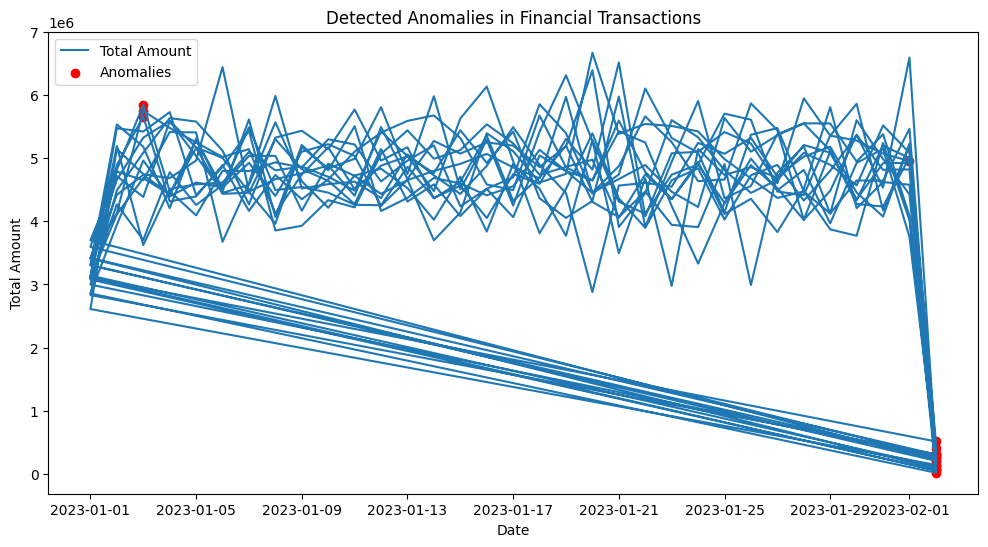

In [ ]:
# Examine the anomalies
anomaly_transactions = daily_transactions[daily_transactions['Is_Anomaly'] == 1]
print(anomaly_transactions)

# Optionally, visualize anomalies
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(daily_transactions['Date'], daily_transactions['Total_Amount'], label='Total Amount')
plt.scatter(anomaly_transactions['Date'], anomaly_transactions['Total_Amount'], color='red', label='Anomalies')
plt.title('Detected Anomalies in Financial Transactions')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.legend()
plt.show()


In [ ]:
# Assuming you have a column in daily_transactions indicating whether a transaction is an anomaly
true_positives = np.sum((anomalies == 1) & (daily_transactions['Is_Anomaly'].values == 1))
false_positives = np.sum((anomalies == 1) & (daily_transactions['Is_Anomaly'].values == 0))
false_negatives = np.sum((anomalies == 0) & (daily_transactions['Is_Anomaly'].values == 1))

accuracy = true_positives / (true_positives + false_positives + false_negatives) if (true_positives + false_positives + false_negatives) > 0 else 0
print(f"Accuracy of anomaly detection: {accuracy:.2f}")


Accuracy of anomaly detection: 1.00
